# Random Forest Classification of Global Terrorist Attacks
### Author: Nina Lopatina, Ph.D.

Global Terrorism Database (GTD) is an open-source database including information on terrorist events around the world from 1970 through 2014. Some portion of the attacks have not been attributed to a particular terrorist group. Original data and information can be found here: http://www.start.umd.edu/gtd/

One very exciting application of machine learning is in finding relationships in large datasets that would escape the human eye. Random Forest Classifiers (RFC) are supervised ensemble-learning models that perform well with large numbers of classes. In this notebook, I have used location, attack type, weapons used, description of the attack, etc. to build an RFC model that can predict what group may have been responsible for an incident. An accurate model would provide great utility in attributing terrorist attacks to the responsible groups. 

## Introduction: 

### Rationale:
The volume and sparseness of these data set provides an interesting multilabel classification challenge: the GTD Database has 170349 entries with 135 variables. 78306 of the recorded attacks are unattributed: that's 45% of the data. There are 3454 known groups. The median # of attacks per group is 2, and, 75% of groups commit 5 or fewer attacks. 

### Background:
Others have achieved fairly high accuracy attributing with this dataset. In "Terrorist Group Prediction Using Data Classification" by Faryal Gohar, Wasi Haider Butt, Usman Qamar, the authors  proposes  a  novel ensemble  framework  for  the  classification  and prediction of the terrorist group that consists of four base  classifiers  namely;  naïve  bayes  (NB),  K nearest neighbour (KNN), Iterative Dichotomiser 3 (ID3) and decision stump (DS). Majority vote based ensemble  technique (MV) is  used  to  combine  these classifiers. They obtained 92.75% accuracy with Naïve Bayes & 93.4% with their combined MV method. There are several reasons why this accuracy is higher than I would expect to find in solving this problem: they thresholded their data to the most frequently active groups: 6 or more attacks. Also, their research was done with the data up to 2012, which had much less data than the current data set. Further, they didn't specify how they split up their training & test sets or other specifics of their statistical methods. source: https://www.researchgate.net/publication/268445148_Terrorist_Group_Prediction_Using_Data_Classification

## Methods:

### Visualization:
I started with some numbers to grasp the nature of the problem: how many data points are there? how many groups? how many attacks are unattributed? how much of the data is missing? To better understand the data, I visualized some of the variables in bar plots and scatter plots to see how much variance there is within variables. Some variables I visualized between the attributed & unattributed attacks. 

To better understand the nature of the classification problem, I visualized the distribution of the known groups and the number of missing data points by variable.

In the process of constructing my model, I visualized some data about the features or of the classification results: correlation between model variables, feature contribution to the model. To better understand my model, I examined classification accuracy by sample size. For model comparison, I visualized accuracy & speed of the models I was comparing. 

Lastly, to verify my final results, I visualized locations of attributed and unattributed attacks that the model posited were by the same group.

### Data engineering:
I approximated 4606 missing values for latitude and longitude by passing city/country data through a geolocation package. 

### Model selection: 
A random forest is supervised classification algorithm. It is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The output is the mode of the class output of all the trees in the forest. I chose this model because it works well with sparse data sets with a high number of classes. Further, if there are enough trees in the forest, the classifier won’t overfit the model. Lastly, RFC will identify and select the most important features from the training dataset, a critical advantage in a datset with 32 features. 

### Model comparison:
For model comparison, I compared RFC to alternative models that can also be used for multiclass classification, the scikit-learn models: RandomForestClassifier, LinearDiscriminantAnalysis, DecisionTreeClassifier, GaussianNB, KNeighborsClassifier, MLPClassifier, LogisticRegression, LinearSVC, GradientBoostingClassifier.   

### Feature engineering:
I added absolute time to the separate year/month/day data (YMD), as well as day of the week. I used 32 features in my model. The top 5 features that contributed most to the model were: longitude, latitude, nationality, country, YMD, the latter of which I had added to the model. YMD contributed more than just the year. 

While Random Forest (RFC) performs feature importance + selection internally, I also tried removing the features that contributed least to the model to see how performance changed. It did not. I ultimately decided not to remove any features. 

## Results: 

### Classification accuracy ground truth, testing on attributed attacks:
RFC classification accuracy is 85.1% for a 10% test set. There's some overfitting: 99% accuracy for the training set. Most of the groups with few samples have low accuracy, and most of the groups with many examples have pretty high accuracy. But there are a few values that don't fit this trend, as highlighted in Section IX-4. 

### Classification of unattributed attacks:
There isn't a clear way to validate these results. First pass visualization of the location of unknown attacks with known attacks fits some expectations: Groups with a sizable number of attacks have more attacks attributed to them in a similar location as a function of other variables. Neo-nazi extremists have 4x as many unattributed as attributed attacks since their responsibility for their attacks tends to be discovered, not claimed. Boko Haram, despite their high level of terrorist activity, has no unattributed attacks: this is because they claim 100% of their attacks. That the model picked up on these differences (from the 'claimed' variable') is a testament to its viability. The model can be improved as detailed below.

## Conclusions:
Classification accuracy with only a handful of samples for many labels is no small feat: the labels are just so sparse. But figuring out where labels from high sample classes are getting mis-classified would increase classification accuracy, without relying on sparse data. Also, it is reasonable to assume that some unattributed attacks are by groups that were not previously known. The model does not currently address this. 

## Next steps: 
1. There are some highly active groups with low classification accuracy that I think could be improved via feature engineering or combining model outputs. I think this could improve the accuracy of the model. 
2. The model doesn't take into account groups that are unknown and also not in the previously known groups. I would improve this by factoring in classification confidence in the label: i.e., if the classification is below a certain bound, guess that it's an unknown unknown group that did this, rather than one of the pre-existing classes. Alternatively, I could combine model outputs with a classifier that can predict an unknown label. 
3. Tweaking the model: sweep parameters that control the complexity: Tree depth, n features to consider for the split, and the minimal number of samples at terminal leaf node.
4. Improving the accuracy of the latitude & longitude data fill. This would involve cross-referencing other geolocation packages.
5. Processing the text in the features I'm not using to add more data to the model
6. Adding more analysis to compare attributed and unattributed attacks by group. 

## Load packages:

In [1]:
import time
import datetime
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from IPython.display import Image
import seaborn as sns #remove?
from geopy.geocoders import Nominatim

#different models to compare:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

#modeling tools: 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

## Set parameters, directories, and options:
dir_main is where the data directory is stored

In [2]:
#parameters
reading = 2 #1 to load up the excel file , 2 is load pickle
quick = 0 #1 to skip some steps while debugging

#relevant directories and file names
dir_main = '/Users/ninalopatina/Box Sync/GTD/'
dir_data = 'GTD_0617dist/'
data_file = 'globalterrorismdb_0617dist.xlsx'
data = dir_main + dir_data + data_file #where the xlsx with the data is stored
location_fix_path = dir_main + dir_data  #data directory for the location fixing pickle
pickle_path = data + '.p' #pickle file of the .xlsx

## I. Load the data
Save in a pickle for faster re-load

In [3]:
#get the excel data into a dataframe
if reading == 1: #reading excel: this is very time-consuming!
    df = pd.read_excel(data)
    df.to_pickle(pickle_path)  #pickled it to open faster after the initial load
elif reading == 2: #reading pickle
    df = pd.read_pickle(pickle_path) #excel data

### Get some basic parameters of the data set:

In [4]:
#how big is this data set?     
num_entries = df.index.max()
num_variables = len(df.columns)
print(str(num_entries) + ' entries with ' + str(num_variables) + ' variables')

#how many are unknown?
unknowns = sum(df['gname']=='Unknown')
print(str(unknowns) + ' unattributed attacks: ' + str(100 * unknowns/num_entries) + '% of data')

#how many groups are there?
ngroups = len(np.unique(df.gname))
print(str(ngroups) + ' known groups')

170349 entries with 135 variables
78306 unattributed attacks: 45% of data
3454 known groups


## II. Add & clean up a few variables:
1) is the attacker known? 
2) numeric label for group name
3) absolute time (year + month + day), to make better use of the month &  day data, which is not as useful on its own
4) day of week

In [5]:
#0 make sure that Unknown is consistent
df = df.replace('unknown', 'Unknown') #this can cause issues in city/country

#1) known?
df['known'] =1 #initialize this column assuming group is known
df.at[df.gname == 'Unknown','known'] = 0 #mark all the unknown

#2) group number
y = df['gname'].copy()
labelencoder_y_1 = LabelEncoder()
y[:] = labelencoder_y_1.fit_transform(y[:])
df['gname_num'] = y

#change year to year since the database started:
df['abs_year'] = df['iyear']-df['iyear'].min()

#3) Absolute time from start: year + month + day
df['year_month_day'] = df['abs_year'] * 365 + df['imonth'] * 30.4 + df['iday'] 
df['year_month_day'] = df['year_month_day'].astype(int)

#4) Day of week:
days = []
for y,m,d in zip(df['iyear'].values,df['imonth'].values,df['iday'].values):
    if (m>0) & (d>0):
        day = datetime.datetime(y,m,d).weekday() #Return the day of the week as an integer, where Monday is 0 and Sunday is 6.
    else:
        day = 8 #unknown day
    days.append(day)
df['day_of_week'] = days

## III. Visualization

### 1. A few quick visualizations 
To get a feel for where/when/how terrorism happens. 

For variables that have a lot of different entries, we're just looking at the top __ , # set by nplot in parameters above

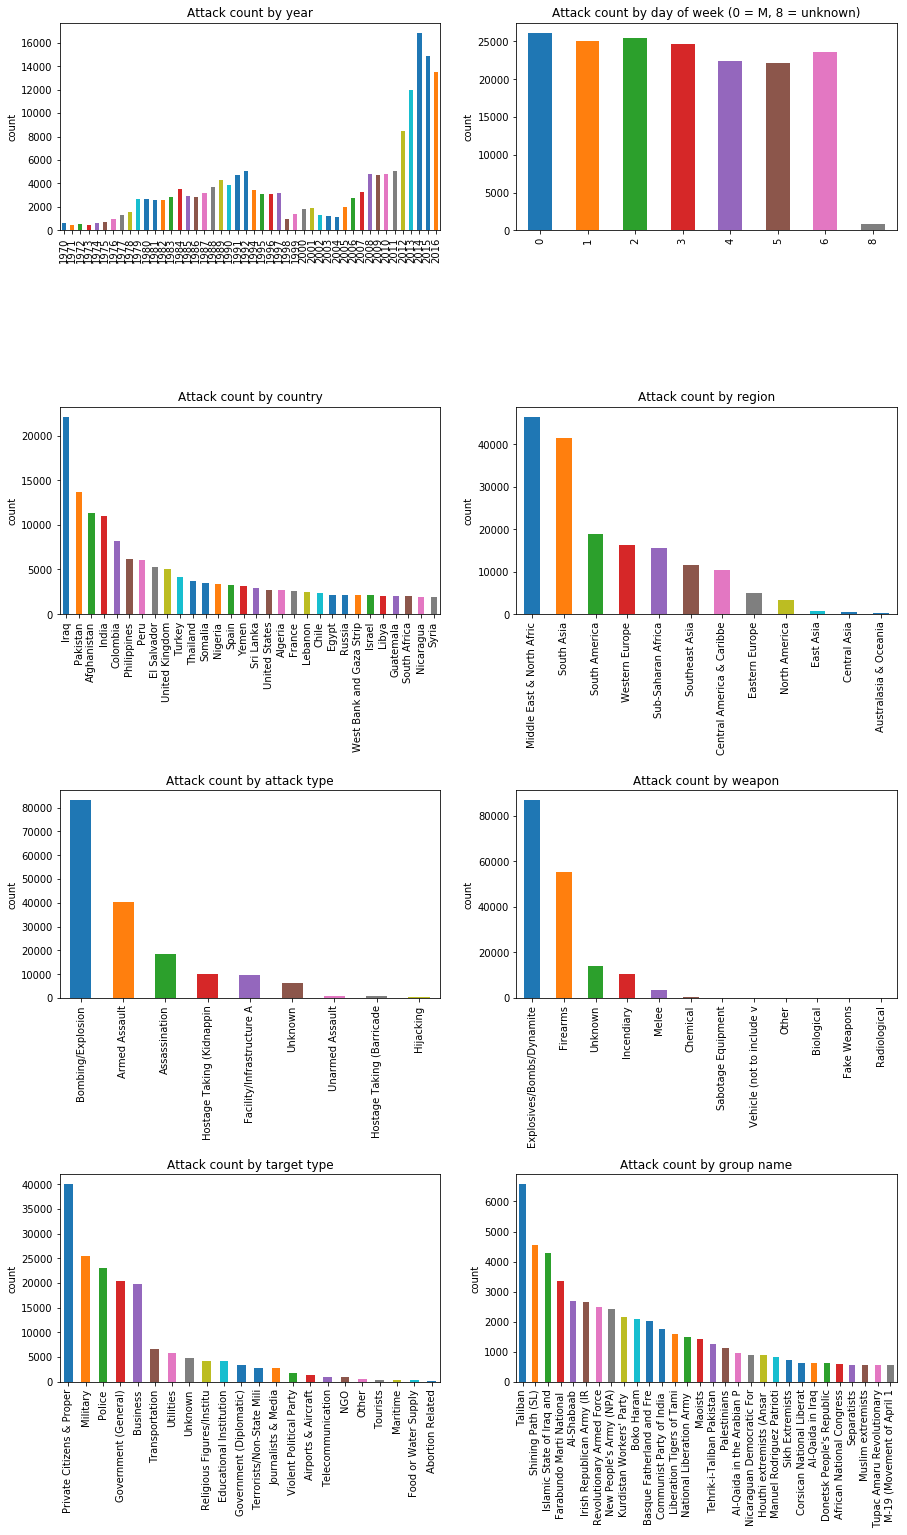

In [6]:
if quick == 0: #don't plot if debugging
    quick_groups = ['iyear','day_of_week','country_txt','region_txt','attacktype1_txt','weaptype1_txt',
                    'targtype1_txt','gname']
    titles = ['year','day of week (0 = M, 8 = unknown)','country','region','attack type','weapon',
              'target type','group name']
    misc_var = 'eventid' #any variable to plot after you run groupby
    nplot = 30 #number of values to plot in quick view plots
    hsp = 0.85 #horiz space between plots
    plots = len(quick_groups)
    fig, axes = plt.subplots((plots/2), 2,figsize=[15,25])

    def bar_plot_labels(ax,title):
        hspace = .9
        ax.set_ylabel('count'),  ax.set_title('Attack count by ' + title)
        ax.set_xlabel('')
        plt.subplots_adjust(hspace = hsp)
        #some of these entries are too long. they're aribitrarily truncated
        #for visualization purposes, but the full names can be seen in 
        #grpd for that plot. 

        #truncate the x-tick labels that are too long: 
        labels = [item.get_text() for item in ax.get_xticklabels()]
        labels = [item[:25] for item in labels]
        ax.set_xticklabels(labels)
    
    def plot_var(var,misc_var,ax, title,df_plot):
        grpd = df_plot[[misc_var,var]].groupby(var).count()    
        if (var != 'iyear') & (var != 'day_of_week'): 
           #just plot the top (nplot) if there's too many, unless it's year
            grpd = grpd.nlargest(nplot,misc_var)
        grpd[misc_var].plot.bar(ax = ax)

        bar_plot_labels(ax,title)
        return grpd

    for ax, var, title in zip(axes.flat, quick_groups, titles):
        if var == 'gname':
            grpd = plot_var(var,misc_var, ax, title,df_plot = df[df['known']==1])
        else:
            grpd = plot_var(var,misc_var, ax, title,df_plot = df)

## Figure 1. Variable visualization. 

I'm fairly unfamiliar with terrorism, so a few facts stand out to me: there's been a sizable uptick since 2012. The US is top ~15, and there are 3 European countries in the top 30, which is less than I'd expected given media coverage of terrorist attacks in these locations. Attack types & weapon are consistent with media reports. There's a steep drop off in the # of attacks by group after the most active groups. 

There are a lot of groups, so I want to get a sense of how sparse the data for each group, visualizing the groups that aren't seen above. 

### 2. Visualizing the classification challenge: how many samples are there per group?

In [7]:
#make a dictionary of group # & names for future reference:
name_num = dict(zip(df['gname_num'].values,df.gname))

Mean attacks per group: 27.0


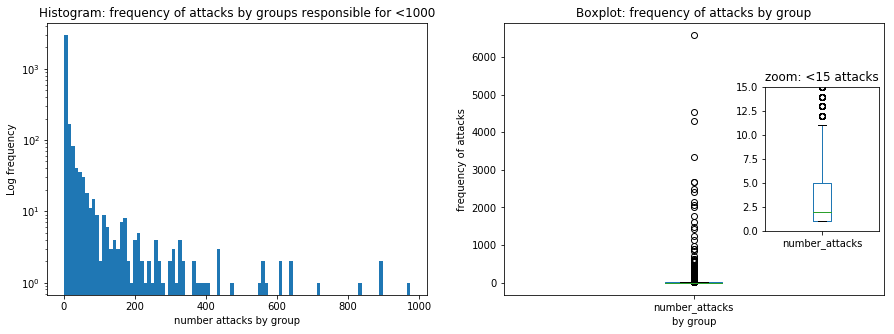

In [8]:
if quick == 0: #don't plot if debugging
    var = 'gname_num'
    grpd = df[df['known']==1][[misc_var,var]].groupby(var).count()
    grpd = grpd.rename(columns={'eventid':'number_attacks'})
    print('Mean attacks per group: ' + str(round(grpd.mean())))

    #plot the ones that don't appear in the bar plot above: 
    fig, axes = plt.subplots(1, 2,figsize=[15,5])

    #histogram of groups that have <1000 attacks
    cutoff,ax = 1000, axes[0]
    grpd2 = grpd[grpd['number_attacks']<cutoff] #limit to the ones we can't see above
    grpd2['number_attacks'].plot.hist(bins=100, ax=ax)
    ax.set_ylabel('Log frequency') 
    ax.set_xlabel('number attacks by group') 
    ax.set_title('Histogram: frequency of attacks by groups responsible for <' + str(cutoff))
    ax.set_yscale('log')

    #the histogram shows a dense distribution for groups that commit <~20 attacks:
    #so we will look at a box plot to get the mean & quartiles for these
    ax = axes[1]
    grpd['number_attacks'].plot.box(ax = ax)
    ax.set_xlabel('by group'), ax.set_ylabel('frequency of attacks')
    ax.set_title('Boxplot: frequency of attacks by group')

    #zoom in on <15 attacks because the outliers are so dispersed: 
    inset_axes = inset_axes(ax, 
                        width="30%", # width = 30% of parent_bbox
                        height=2, # height : 1 inch
                        loc=5)
    miniax = grpd['number_attacks'].plot.box()
    cutoff = 15
    miniax.set_ylim(0,cutoff), miniax.set_title('zoom: <'+str(cutoff) + ' attacks');

## Figure 2. Frequency of attacks by group 

The above indicates a major challenge for classifying the group: the median # of attacks per group is 2, and, 75% of groups commit 5 or fewer attacks. The sparseness of this data set will be a major challenge. 

### 3. Do the known and unknown attacks share characteristics?
#### i. Plot the latitude & longitude for each entry:

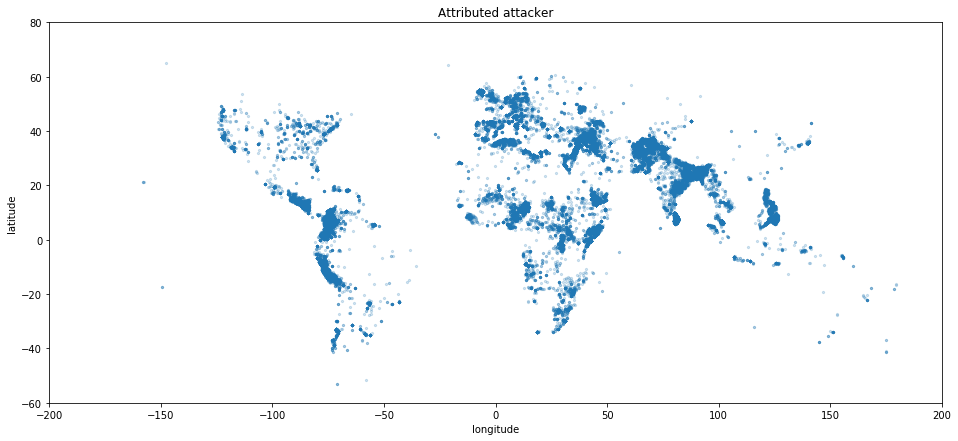

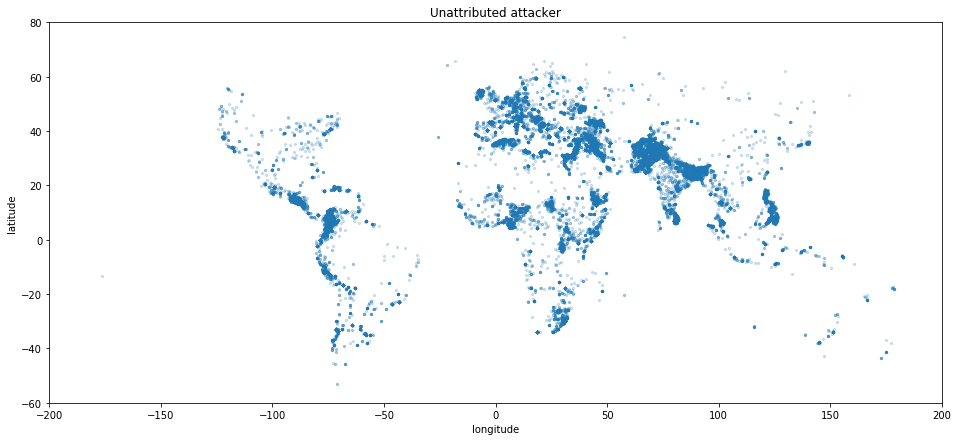

In [9]:
if quick == 0: #don't plot if debugging
    def plot_map(dff,title):
        p = dff.plot(kind= 'scatter', x='longitude', y='latitude',s = 5, alpha=0.2, figsize=(16,7))
        p.set_title(title), p.set_xlim([-200,200]), p.set_ylim([-60,80])
        plt.show()

    plot_map(df[df['known']==1],title='Attributed attacker')
    plot_map(df[df['known']==0],title='Unattributed attacker')

## Figure 3. Latitude & Longitude of attributed & unattributed attacks. 

Maps look roughly similar. Looks like there are more known than unknown attackers in the Americas and Africa compared to Europe.

What about the weapon type and attack type? Are there inherent differences in these data based on which groups either claim the attack or are caught for the attack? 

#### ii. Plot variables by whether the attacker is known or unknown:

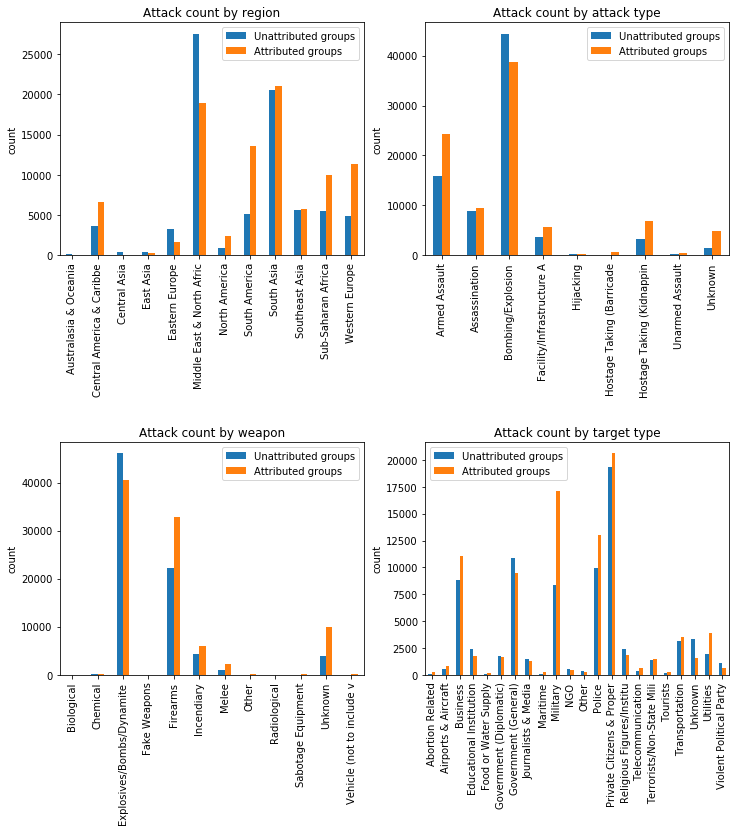

In [10]:
if quick == 0: #don't plot if debugging
    quick_groups = ['region_txt','attacktype1_txt','weaptype1_txt','targtype1_txt']
    titles = ['region','attack type','weapon','target type']
    misc_var = 'eventid' #any variable to plot after you run groupby
    hsp = 0.8 #horiz space between plots
    
    plots = len(quick_groups)
    fig, axes = plt.subplots((plots/2), 2,figsize=[12,12])

    def plot_2var(var,misc_var,ax, title,df_plot):
        var2 = 'known'
        grpd = df[[misc_var,var,var2]].groupby([var,var2]).count() 
        grpd.unstack().plot.bar(ax=ax)
        bar_plot_labels(ax,title)
        L = ax.legend()
        L.get_texts()[0].set_text('Unattributed groups')
        L.get_texts()[1].set_text('Attributed groups')
        return grpd, L

    for ax, var, title in zip(axes.flat, quick_groups, titles):
        grpd, L = plot_2var(var,misc_var, ax, title,df_plot = df)

## Figure 4. Variables split by attributed or unattributed group 

At a glance: More unattributed attacks in the Middle East and North Africa; more attributed in South America. Armed assualt & attacks on the military are more likely to be by attributed groups as well

## IV) Data selection:
Select the variables for the model

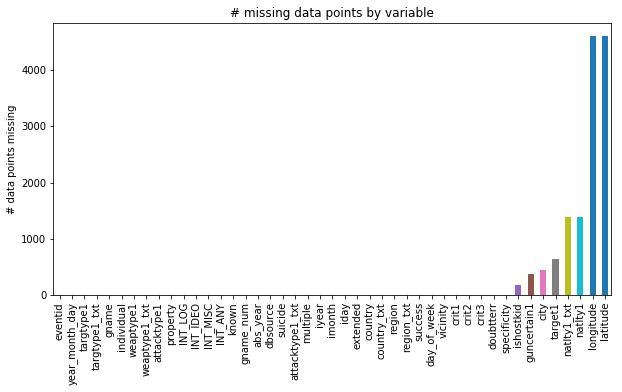

In [11]:
#how many missing values are there per feature? Let's stick to variables with <5000 missing values
nan_limit = 5000 # how many nan are ok? 
check_nan = df.isnull().sum()

if quick == 0: #don't plot if debugging
    ax = check_nan[check_nan<nan_limit].sort_values().plot.bar(figsize = [10,5])
    ax.set_title('# missing data points by variable'), ax.set_ylabel('# data points missing');

## Figure 5. Missing data points by variable with <5000 data points missing

### 1. Select variables without too much missing data: 
There are a lot of variables with <5000 missing values. Let's stick to the ones that contain integer values.

In [12]:
#start with all the variables without too many missing values
viable_variables = check_nan[check_nan<nan_limit].index
print('initial list:')
print(viable_variables.values)
#drop the ones that are not viable: text values, columns I"ve added, etc.
#The variable names I'm removing are based on the columns I can see in the excel + the pdf explainer
viable_variables = viable_variables.drop(['eventid','abs_year','known'])
viable_variables = viable_variables[viable_variables.isin(df.columns[df.dtypes != 'object'])] #remove text

print('culled list:')
print(viable_variables.values)       

initial list:
[u'eventid' u'iyear' u'imonth' u'iday' u'extended' u'country'
 u'country_txt' u'region' u'region_txt' u'city' u'latitude' u'longitude'
 u'specificity' u'vicinity' u'crit1' u'crit2' u'crit3' u'doubtterr'
 u'multiple' u'success' u'suicide' u'attacktype1' u'attacktype1_txt'
 u'targtype1' u'targtype1_txt' u'target1' u'natlty1' u'natlty1_txt'
 u'gname' u'guncertain1' u'individual' u'weaptype1' u'weaptype1_txt'
 u'property' u'ishostkid' u'dbsource' u'INT_LOG' u'INT_IDEO' u'INT_MISC'
 u'INT_ANY' 'known' 'gname_num' 'abs_year' 'year_month_day' 'day_of_week']
culled list:
[u'iyear' u'imonth' u'iday' u'extended' u'country' u'region' u'latitude'
 u'longitude' u'specificity' u'vicinity' u'crit1' u'crit2' u'crit3'
 u'doubtterr' u'multiple' u'success' u'suicide' u'attacktype1'
 u'targtype1' u'natlty1' u'guncertain1' u'individual' u'weaptype1'
 u'property' u'ishostkid' u'INT_LOG' u'INT_IDEO' u'INT_MISC' u'INT_ANY'
 'gname_num' 'year_month_day' 'day_of_week']


## V) Fixing missing data: latitude & longitude
There are a lot of latitude & longitude values missing. I know these are my most important features from checking the feature importance from the Random Forest Classifier (near the bottom of this notebook). I can't exclude this variable, nor do I want to throw away all these samples. Further, if I don't fill in these values for the unknown lats & longs for Unknown groups, then my model won't be able to predict which group was responsible. 

In [13]:
#missing values:
print('Missing values:')
check_nan[['longitude','latitude']]

Missing values:


longitude    4606
latitude     4606
dtype: int64

The code below approximates most of the latitude + longitude values, but has a bug somewhere that I will fix at a later point. 

In [14]:
if reading == 2: #reading pickle; I highly recommend this option
    df_fix = pd.read_pickle(location_fix_path+'df_fix.p')
    
elif reading == 1: #if running this for the first time: very time-consuming
#This package has a lot of service time outs, so storing some of the country lat/long locally to minimize calls to API 

    #initialize dataframe with the missing values & fix a few entries: 
    df_fix = df[['latitude','longitude','city','country','country_txt','region', 'region_txt']][df['longitude'].isnull()]
    
    #People's Republic of the Congo is no longer a country:
    df_fix.loc[df_fix['country_txt']=="People's Republic of the Congo",'country_txt'] = 'Republic of the Congo'
    #Not trying to get political here: this looked like the search term that gave the best average of West Bank + Gaza
    df_fix.loc[df_fix['country_txt']=="West Bank and Gaza Strip",'country_txt'] = 'Palestinian territories, Israel'
    #There are some NaN values in the city values: 
    df_fix.loc[df_fix['city'].isnull(),'city'] = 'Unknown'
  
    geolocator = Nominatim()

    def country_func(country,df_fix,geolocator):          
        if country == 'Unknown':#  get lat/long from region 
            region = df_fix.loc[i,'region_txt'] 
            location = geolocator.geocode(region)
            latitude, longitude = location.latitude, location.longitude
        else:
            location = geolocator.geocode(country)
            latitude, longitude = location.latitude, location.longitude
        return latitude, longitude
    
    # I tried looking up a few cities the package couldn't find. I googled a few to try to figure out what the issue
    # is. I ultimately decided to just skip the ones the package couldn't find, but I am including the values I was 
    # able to find here. I'd ordinarily put these into a separate text file but there's so few I'm just keeping them here. 
    misc_city = pd.DataFrame([['Tarlas',15.4470,120.4696],['Penghu Islands',22.6158,120.7120],
                             ['Mirror Newspaper', 16.8661,96.1951],['Penjwon',35.6239,45.9491]],
                             columns=['city','latitude','longitude'])
    
    count = 0 #this tends to time out, so just put the last count before it crashed to resume
    done = 0
    while done == 0:
        for i in df_fix.index[count:]: 
            if count == len(df_fix)-1:
                done = 1
                break
            count = count + 1
            city, country = df_fix.loc[i,'city'],df_fix.loc[i,'country_txt']  
            try: 
                 #have we already entered a value for this city, country combo? 
                if df_fix[df_fix.index<i]['city'].str.contains(city).any(): #have this city
                    #in the same country:
                    if df_fix[df_fix.index<i].loc[df_fix[df_fix.index<i]['city'] == city,'country_txt'].str.contains(country).any(): 
                        row = df_fix.loc[(df_fix['city'] == city) & (df_fix['country_txt'] == country)].index[0]
                        latitude,longitude = df_fix.loc[row,'latitude'],df_fix.loc[row,'longitude'] 
                elif city == 'Unknown': #get by country
                    latitude,longitude = country_func(country,df_fix,geolocator)
                elif misc_city.city.str.contains(city).any(): #a few cities I looked up manually
                    row = misc_city.loc[(misc_city['city'] == city)].index
                    latitude = misc_city.loc[row,'latitude'].values
                    longitude = misc_city.loc[row,'longitude'].values
                else:
                    location = geolocator.geocode(city + ',' + country)   
                    if location is None: #don't have city, so try country:
                        latitude, longitude = country_func(country,df_fix,geolocator)
                    else: #store the values
                        latitude, longitude = location.latitude, location.longitude
                df_fix.loc[i,'latitude'] = latitude
                df_fix.loc[i,'longitude'] = longitude  
            except:
                print(count)
                continue
    #save this dataframe to pickle 
    df_fix.to_pickle(location_fix_path + 'df_fix.p')


In [15]:
#replace NaN latitudes & longitudes with the values I found:
df.loc[df['latitude'].isnull(),'latitude'] = df_fix.latitude #they're always missing in pairs
df.loc[df['longitude'].isnull(),'longitude'] = df_fix.longitude

#now there are fewer missing values:
check_nan = df.isnull().sum()
print('Missing values:')
print(check_nan[['longitude','latitude']])

Missing values:
longitude    132
latitude     132
dtype: int64


We've approximated >4000 latitude and longitude values.

## VI) Set up the dataframe for the model:
Are any data still missing? 
For the other variables with missing data, it's easier to just delete those values rather than try to figure them out. 

In [16]:
def get_model(viable_variables,dfm, kn):
    df_model = dfm[viable_variables][dfm['known']==kn] #just the variables we're interested in, for known groups

    #for now: remove rows that are missing values
    lenn1 = len(df_model)
    print(str(lenn1)+' rows including NaN')
    df_model = df_model.dropna()

    lenn2 = len(df_model) 
    print(str(lenn2)+' rows without NaN') 

    print(str(lenn1 - lenn2) + ' rows deleted')
    return df_model

df_model = get_model(viable_variables,dfm = df, kn = 1) #kn = 1 means known groups

92044 rows including NaN
90860 rows without NaN
1184 rows deleted


### Visualize our model data:
How correlated are the variables we picked for our model? 

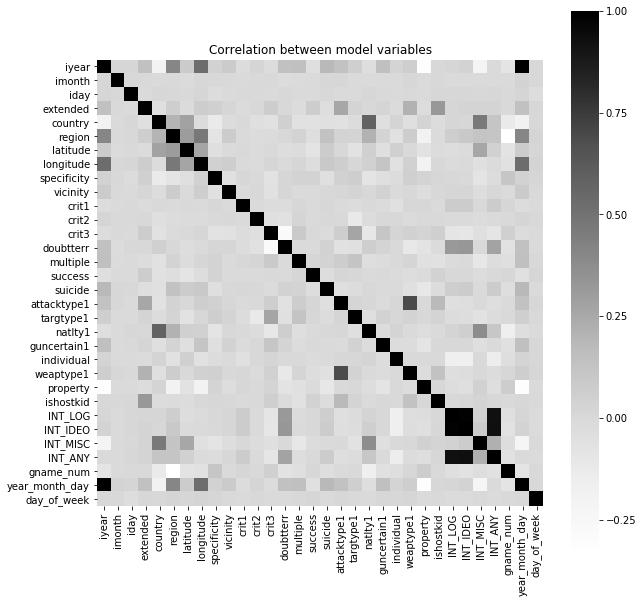

In [17]:
if quick == 0: #don't plot if debugging
    corrmat = df_model.corr()
    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(corrmat, vmax=1, square=True,cmap="Greys");
    ax.set_title('Correlation between model variables')
    plt.show()

## Figure 6. Correlation between model features

There's some correlation between country, region, latitude, and longitude, which we would expect. Likewise, between country & nationality, and, attacktype & weapontype.

Interestingly, there is a correlation between the year & region/longitude, which suggests that attacks cluster in time.

## VII) Compare models that can classify multiple classes on a sample data set: 
RBC seems like it'll perform best, but this assumption requires validation. 

Our dataframe has a lot of classes, so we'll also make a smaller subset for testing classifiers, since some of these will take a long time to run:

### 1) Make a shuffled subset of the groups :

In [18]:
sample_size = 300 #sample size
population = range(ngroups)
samp_groups = random.sample(population, sample_size)
df_sample = df_model[df_model['gname_num'].isin(samp_groups)]

Note: the above sampling does not currently control for the number of samples per group or the sample matching the population with respect to the other variables. 

### 2) Split up the data and the model labels

In [19]:
def Xy(df_split):    
    X = df_split[df_split.columns[df_split.columns != 'gname_num']]#all variables besides gname
    y = df_split['gname_num']
    return X,y

X,y = Xy(df_split=df_sample)

#to scale the data, run the below:
#min_max_scaler = preprocessing.MinMaxScaler()
#X = min_max_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### 3) Function to run the model and output accuracy and run time:

In [20]:
def get_accuracy(model,model_name,df_acc,X_train, y_train,X_test,y_test):
    now = time.time()
    mdl = model()
    mdl.fit(X_train, y_train)
    preds_test = mdl.predict(X_test)
    preds_train = mdl.predict(X_train)
    #add to next row:
    nr = len(df_acc)
    df_acc.loc[nr,'model'] = model_name
    df_acc.loc[nr,'test_accuracy'] = int(accuracy_score(y_test,preds_test)*100) #multiply by 100 for rough plotting
    df_acc.loc[nr,'train_accuracy'] = int(accuracy_score(y_train,preds_train)*100)
    df_acc.loc[nr,'time'] = int(time.time()-now)
    return df_acc

### 4) Run through all the models in the below list to get their accuracy

In [21]:
if quick == 0: #don't run if debugging
    #make a dataframe to store accuracy and time
    df_acc = pd.DataFrame(columns = ['model','train_accuracy','test_accuracy','time'])

    #models to try:
    models = [LinearDiscriminantAnalysis,DecisionTreeClassifier,GaussianNB,KNeighborsClassifier,
              RandomForestClassifier,MLPClassifier,LogisticRegression,LinearSVC]
    model_names = ['LDA','DecisionTree','GaussNaiveBayes','KNN','RandomForest','MLP','LogReg','LinSVC']

    #notes: for KNN, could tweak n_neighbors. 

    for model, model_name in zip(models,model_names):
        df_acc = get_accuracy(model,model_name,df_acc,X_train, y_train,X_test,y_test)

/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


### 5) Separate code for the Gradient Boosting Classifier because a lot of parameters need to be set within the function:

In [22]:
if quick == 0: #add GBC
    now = time.time()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    # It is important to train the ensemble of trees on a different subset
    # of the training data than the linear regression model to avoid
    # overfitting, in particular if the total number of leaves is
    # similar to the number of training samples
    X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                                y_train,
                                                                test_size=0.2)
    n_estimator =10
    grd = GradientBoostingClassifier(n_estimators=n_estimator)
    grd_enc = OneHotEncoder()
    grd_lm = LogisticRegression()
    grd.fit(X_train, y_train)
    grd_enc.fit(grd.apply(X_train)[:, :, 0])
    grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

    y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
# fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)    
  
    # The gradient boosted model by itself
    y_pred_grd = grd.predict_proba(X_test)[:, 1]
#     fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

    preds_test = grd.predict(X_test)
    preds_train = grd.predict(X_train)
    
    nr = len(df_acc)
    df_acc.loc[nr,'model'] = 'GBC'
    df_acc.loc[nr,'test_accuracy'] = int(accuracy_score(y_test,preds_test)*100) #multiply by 100 for rough plotting
    df_acc.loc[nr,'train_accuracy'] = int(accuracy_score(y_train,preds_train)*100)
    df_acc.loc[nr,'time'] = int(time.time()-now)

### 6) Plot the relative times and accuracies:
The scatters show up on top of each other sometimes: to be fixed at a later point. 

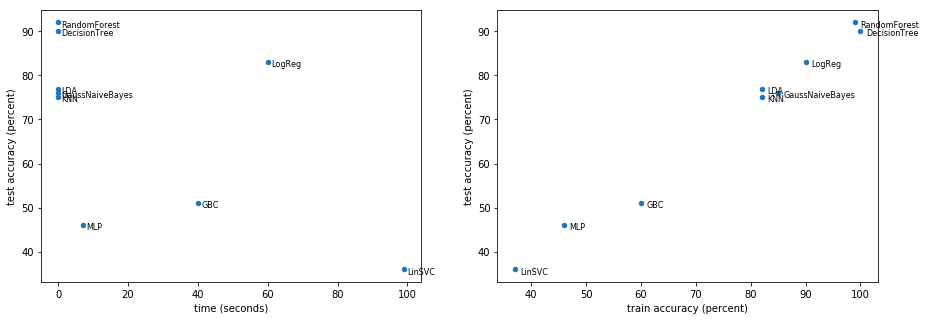

In [23]:
def scatterp(df_plot,x,y,ax,xlabel,ylabel,title):
    df_plot.plot.scatter(x,y,ax = ax)
    for i, txt in enumerate(df_plot.model):
        ax.annotate(txt, (df_plot[x].iat[i]+1,df_plot[y].iat[i]-1),fontsize = 8)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def make_scatter(df_plot):
    df_plot[df_plot.columns[df_plot.columns != 'model']] = df_plot[df_plot.columns[df_plot.columns != 'model']].astype(int)
    fig, axes = plt.subplots(1,2,figsize = [15,5])

    # plot time vs test accuracy 
    scatterp(df_plot=df_acc,x='time',y='test_accuracy',ax=axes[0],xlabel='time (seconds)',
             ylabel='test accuracy (percent)',title = 'Speed-accuracy trade-off: Test accuracy vs. time')

    #plot train vs. test accuracy 
    scatterp(df_plot=df_acc,x='train_accuracy',y='test_accuracy',ax=axes[1],xlabel='train accuracy (percent)',
             ylabel='test accuracy (percent)',title = 'Are we overfitting? Test accuracy vs. Train accuracy')

if quick == 0:
    make_scatter(df_plot=df_acc)

## Figure 7. Sample data set model comparison between Random Forest, Decision Tree, Gaussian Naïve Bayes, K-Nearest Neighbors, Linear Discriminant Analysis, Logistic Regression, Gradient Boosted Classifier, Multi-layer Perceptron and Linear SVC. 

Based on these results, Random Forest performs best. However, since this is a partial data set, we will need to run a subset of these models on the full data set. 'LDA', 'DecisionTree', 'GaussNaiveBayes', 'KNN' are fast enough to try on the full data set, and have sufficient accuracy for a meaningful comparison to RBC. LogReg has similar accuracy, but is too slow. MLP, LinSVC, and GBC all have relatively low accuracy. 

## VIII) Compare models in the full data set:

### 1) Run through all the models in the below list to get their accuracy

In [24]:
#split up the data and the model labels
X,y = Xy(df_split=df_model)

#scale?
#min_max_scaler = preprocessing.MinMaxScaler()
#X = min_max_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [25]:
#Run all the models:
if quick == 0:
    #models to try:
    models = [LinearDiscriminantAnalysis,DecisionTreeClassifier,GaussianNB,KNeighborsClassifier,
              RandomForestClassifier]
    model_names = ['LDA','DecisionTree','GaussNaiveBayes','KNN','RandomForest']

    #make a dataframe to store accuracy and time
    df_acc = pd.DataFrame(columns = ['model','train_accuracy','test_accuracy','time'])

    for model, model_name in zip(models,model_names):
        df_acc = get_accuracy(model,model_name,df_acc,X_train, y_train,X_test,y_test)

### 2) Plot the relative times and accuracies:

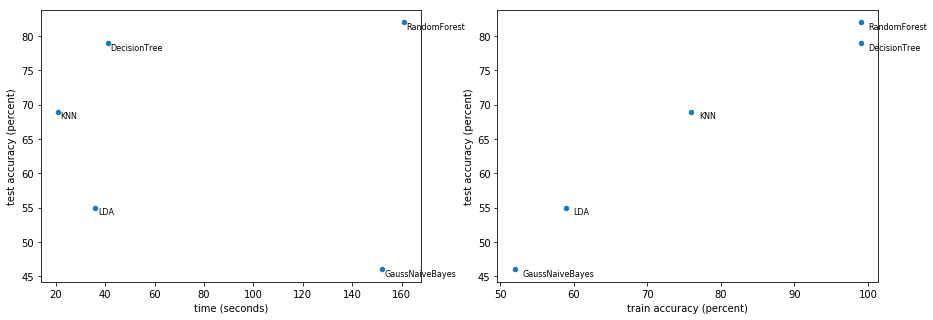

In [26]:
if quick == 0:
    make_scatter(df_plot=df_acc)

## Figure 8. Full data set model comparison between Random Forest, Decision Tree, Gaussian Naïve Bayes, K-Nearest Neighbors, Linear Discriminant Analysis

Random forest is most accurate with the full data set, so let's see if we can make it even more accurate.

## IX) Pick a model and run it with a larger test size and examine the classification errors: 


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
clf = RandomForestClassifier(n_jobs =-2)#,max_depth=2,random_state = 0, warm_start = True)

def get_acc(X_train,y_train,clf,X_test,y_test):
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc_score = accuracy_score(y_test,preds)
    print('Random Forest 50% test accuracy: ' + str(acc_score))
    return preds
    
preds = get_acc(X_train,y_train,clf,X_test,y_test)   

Random Forest 50% test accuracy: 0.810543693594541


### 1) Examine features:

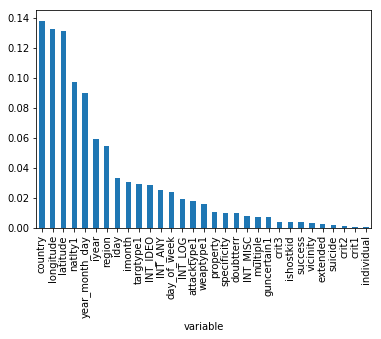

In [28]:
#how much do each of the features contribute? 
df_features = pd.DataFrame(columns = ['variable', 'contribution'])
df_features['contribution'] = pd.Series(clf.feature_importances_)
df_features['variable'] = pd.Series(df_model.columns[df_model.columns != 'gname_num'])
df_features = df_features.sort_values(by='contribution',ascending = False)
p = df_features.plot.bar(x = 'variable',legend= False)
## Figure 7. Model comparison between Random Forest, Decision Tree, Gaussian Naïve Bayes, K-Nearest Neighbors, Linear Discriminant Analysis, Logistic Regression, Gradient Boosted Classifier, Multi-layer Perceptron and Linear SVC. p.set_ylabel('contribution'), p.set_title('Contribution of each variable');

## Figure 9. Variable contribution in RBC classification

### 2) Remove features?
I tried reducing the features but this doesn't do much for RFC because it does its own feature selection. 

In [29]:
reducing= 0
if reducing == 1:
    #Picking features shouldn't matter so much, but lets try this again without worst performing variables: 
    df_features_reduce = df_features.nsmallest(3,'contribution') 
    #I tried the above with a few #s to pick one with comparable acc.
    reduced_variables = viable_variables.drop(df_features_reduce['variable'].values)

    #get a new df
    df_model = get_model(reduced_variables,dfm = df, kn = 1) #kn = 1 means known groups
    X = df_model[df_model.columns[df_model.columns != 'gname_num']]#all variables besides gname
    y = df_model['gname_num']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    clf = RandomForestClassifier(n_jobs =-2)

    preds = get_acc(X_train,y_train,clf,X_test,y_test) 

### 3) Examine the classification accuracy by sample size:
Rather than looking at the entire confusion matrix (there are just way too many groups), let's think about how that could help us classify more accurately. 
sklearn provides a classification report with the number of false positives, false negatives, and number of samples the classification was based on:

In [30]:
clf_rep = classification_report(y_true = y_test, y_pred = preds)

#this report is just text, so needs to be converted to a table
def to_table(clf_rep):
    report = clf_rep.splitlines()
    res = []
    res.append(['']+report[0].split())
    for row in report[2:-2]:
        res.append(row.split())
    lr = report[-1].split()
    res.append([' '.join(lr[:3])]+lr[3:])
    output = np.array(res)
    return output

output = to_table(clf_rep)
#fix column names bc gname_num is missing:
cols = []
cols.append('gname_num')
for item in output[0][1:]:
    cols.append(item)
    
#of course turn it into a dataframe:
out_df = pd.DataFrame(output[1:], columns = cols)#, index = nb.classes_)
out_df = out_df[:-1] #last row is averages

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 4)  Visualize accuracy by how many examples the classifier has:

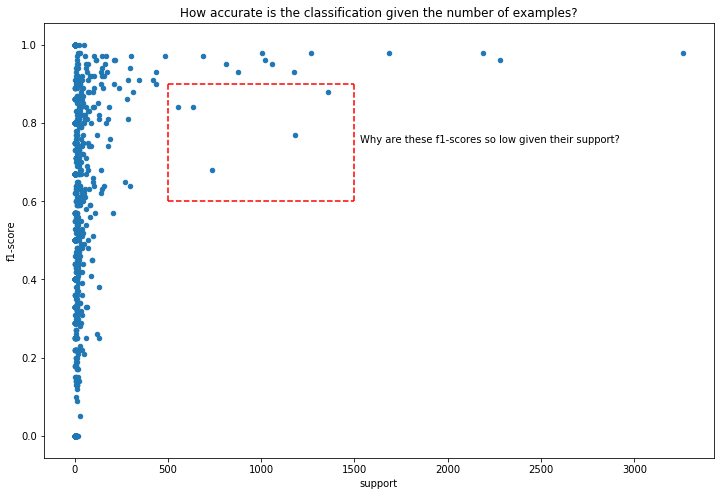

In [31]:
out_df['support']=out_df['support'].astype(float)
out_df['f1-score']=out_df['f1-score'].astype(float)
ax = out_df.plot.scatter(x='support',y='f1-score',figsize = [12,8])
ax.set_title('How accurate is the classification given the number of examples?');

#draw a box to highlight something:
xmi, xma, ymi, yma = 500,1500,.6,.9
ax.plot([xmi,xma],[ymi,ymi],'r--')
ax.plot([xmi,xma],[yma,yma],'r--')
ax.plot([xmi,xmi],[ymi,yma],'r--')
ax.plot([xma,xma],[ymi,yma],'r--')
ax.annotate('Why are these f1-scores so low given their support?', [xma + 30,(ymi+yma)/2]);

## Figure 10. RBC classification accuracy over support

Most of the groups with many examples have pretty high accuracy. But there are a few values that don't fit the trend, as highlighted with the red box above. The values on the left are hard to fix: it's just so sparse. But figuring out where those values are getting mis-classified may be the key to a more accurate classifier.

#### i) Visualize just the classes with high support:

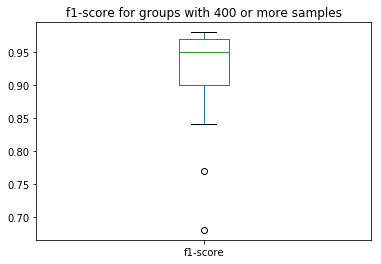

Classification report for the low end of classification accuracy:
     gname_num precision recall  f1-score  support
1168      1432      0.83   0.94      0.88   1356.0
1720      2131      0.66   0.71      0.68    735.0
1864      2313      0.78   0.91      0.84    556.0
2113      2631      0.72   0.82      0.77   1179.0
2470      3077      0.78   0.91      0.84    635.0


In [32]:
robust = 400 #robust class
ax = out_df['f1-score'][(out_df['support']>robust)].plot.box()
ax.set_title('f1-score for groups with ' + str(robust) + ' or more samples')
plt.show()

df_laggards = out_df[(out_df['support']>robust) & (out_df['f1-score']<.9)]
print('Classification report for the low end of classification accuracy:')
print(df_laggards)

## Figure 11. Classification accuracy classes with many samples

To interpret the above: 
T = True, F = False, P = Pos, N = Neg:
Recall is TP/(TP + FN) whereas precision is TP/(TP+FP)
F1-score is harmonic average of the precision and recall

#### ii) Make a list of the high support groups with low classification accuracy from above: 

In [33]:
# which are the groups that are more challenging to classify?
names = df_laggards['gname_num']
print('highly active groups with lower than expected classification accuracy:')
np.unique((df.loc[df['gname_num'].isin(names),['gname','gname_num']]))

highly active groups with lower than expected classification accuracy:


array([1432L, 2131L, 2313L, 2631L, 3077L, u'Irish Republican Army (IRA)',
       u'National Liberation Army of Colombia (ELN)', u'Palestinians',
       u'Revolutionary Armed Forces of Colombia (FARC)',
       u'Tehrik-i-Taliban Pakistan (TTP)'], dtype=object)

#### iii) Plot confusion matrix for just these 5 groups

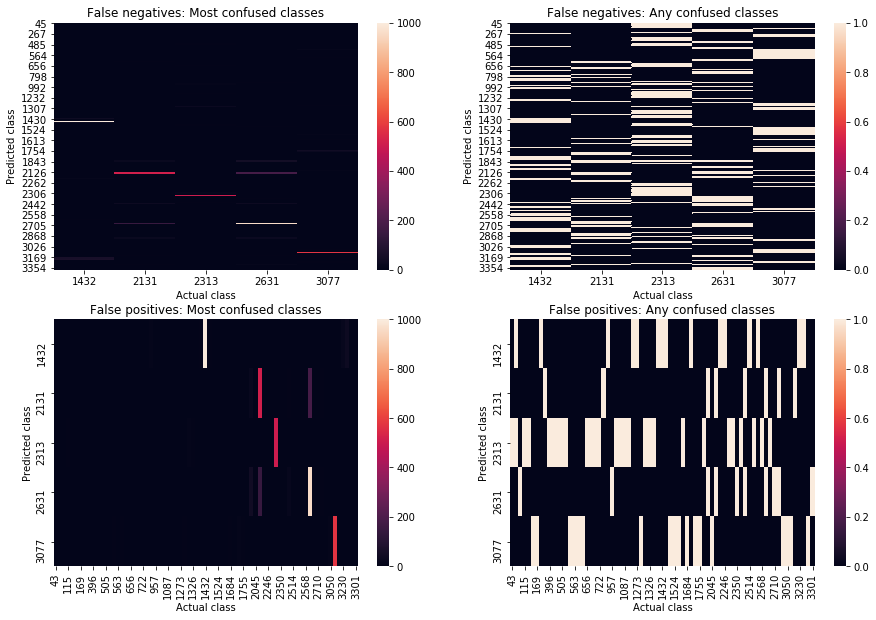

In [34]:
labels = out_df['gname_num'].values.astype(int)
cm = confusion_matrix(y_test, preds,labels=labels)
cm = pd.DataFrame(cm,columns=labels,index=labels) #columns are actual class, rows are predicted class
fn = cm.loc[:,df_laggards['gname_num'].values.astype(int)] #false negative
fp = cm.loc[df_laggards['gname_num'].values.astype(int)] #false positive

#where it was mis-classified:
fn = fn[fn.sum(axis=1)>0]
fp = fp.loc[:,fp.sum(axis=0)>0]
       
f, axes = plt.subplots(2,2,figsize=(15, 10))

def labels(title,ax):
    ax.set_ylabel("Predicted class")
    ax.set_xlabel("Actual class")
    ax.set_title(title)

titles = ['False negatives: Most confused classes','False negatives: Any confused classes',
          'False positives: Most confused classes','False positives: Any confused classes']
dbs = [fn,fn,fp,fp]
vmaxes = [1000,1,1000,1]#add vmax

for ax, db, title,vmax in zip(axes.flat, dbs, titles,vmaxes):
    sns.heatmap(db,vmax=vmax,ax=ax)
    labels(title,ax)

## Figure 12. RBC confuction matrices for high sample, low accuracy classes

A few things to note here: 

1) 2131 & 2631 (ELN & FARC, in Colombia) have a substantial amount of confusion with each other.

2) While there are generally more false positives than false negatives (for these groups), it looks like the false negatives are more sparsely distributed. 

Next steps for this project include looking at the features involved in these miss-classications and try to figure out what feature engineering or model tweaking would improve the accuracy for these groups. For example, comparing accuracy for classifying these groups from some of the other classifiers I used. If any of those are more accurate for particular groups, I could combine their output. Further, if there are some regions where attacks are frequently co-located, i.e. Colombia, I could train a separate classifier for just that region, and find a way to classify with less reliance on geo-location. 

## X) Run the final model on a larger training set, to use to predict the unattributed group names:

In [35]:
# train on more samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# set a high n_estimators to bump the accuracy 
clf = RandomForestClassifier(n_estimators=50,n_jobs =-3)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
preds_train = clf.predict(X_train)
acc_score = accuracy_score(y_test,preds)
acc_score2 = accuracy_score(y_train,preds_train)
print('Final RFC classification accuracy:' + str(acc_score))

Final RFC classification accuracy:0.8481179837112041


Almost done! Now that we have a reasonably accurate model,

## XI) Predict which groups were responsible for some unknown attacks:

In [36]:
#get a new df with just the unknown attacks:
df_unknown = get_model(viable_variables,dfm = df, kn = 0) #kn = 0 means Unknown groups
X_unknown = df_unknown[df_unknown.columns[df_unknown.columns != 'gname_num']]#all variables besides gname

preds_unknown = clf.predict(X_unknown)   
df_unknown['predicted_gname_num']=preds_unknown

78306 rows including NaN
77405 rows without NaN
901 rows deleted


## XII) Lastly, let's visualize some of the predictions from our model to see if they are consistent with what we might expect

In [37]:
def plot_2map(df,df_unknown,check_group):
    fig,ax = plt.subplots(figsize=(16,7))
    n_attributed = len(df[df['gname_num']==check_group])
    n_unattributed = (len(df_unknown[df_unknown['predicted_gname_num']==check_group]))
    title=(str(n_attributed)+' Attributed & '+str(n_unattributed)+' Unattributed attacks by ' + str(name_num[check_group]))
    
    df[df['gname_num']==check_group].plot(kind= 'scatter', x='longitude', y='latitude',
                                          c = 'blue',s = 1, alpha=0.2, ax = ax)
    if n_unattributed >0:
        df_unknown[df_unknown['predicted_gname_num']==check_group].plot(kind= 'scatter', x='longitude', y='latitude',
                                          c = 'red',s = 1, alpha=0.2, ax = ax)
        L = ax.legend(['Attributed','Unattributed'])     
    else:
        print('No unattributed attacks were attributed to this group')
        L = ax.legend(['Attributed','Unattributed'])
    
    ax.set_title(title)# ax.set_xlim([-200,200]), ax.set_ylim([-60,80])

### 1) Neo-nazi extremists
I noticed this group, selected at random, had similar clustering of known & unknown attack sites. But there are much more unattributed attacks than attributed attacks. This makes sense intuitively, because they tend to only be attributed when they're caught. 

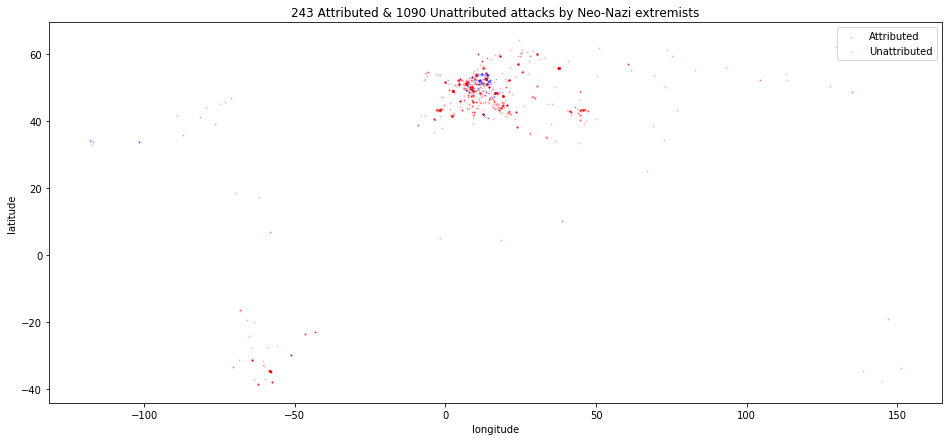

In [38]:
check_group = 2179
plot_2map(df,df_unknown,check_group)

## Figure 13. Location of Attributed vs. Unattributed attacks by Neo-Nazi Extremists

### 2) Boko Haram:

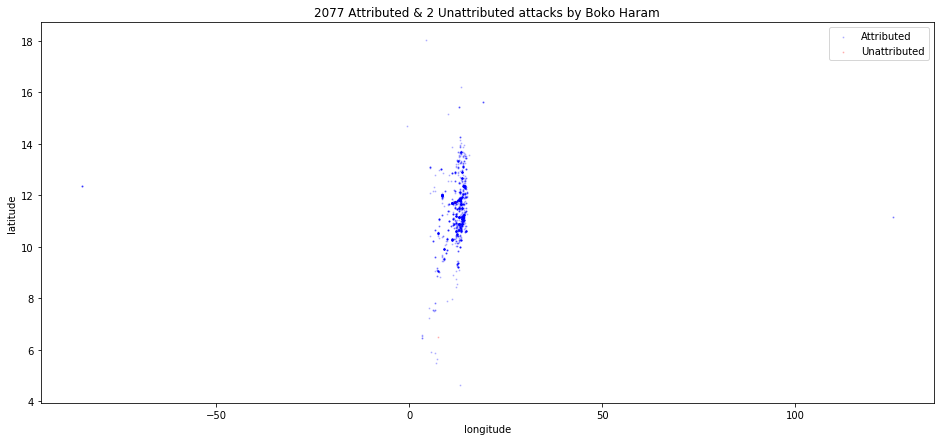

In [39]:
check_group = 678 #Boko Haram
plot_2map(df,df_unknown,check_group)

## Figure 14. Location of Attributed vs. Unattributed attacks by Boko Haram

What about a group with high classification accuracy and a lot of support? I picked Boko Haram sort of by chance (one of the more accurately classified groups), but this is a great example: many known & no unknown attacks. But this is a strong testament to the quality of the model: from my understanding of terrorist acts by Boko Haram, they claim all of their attacks. Thus, there should be no unknown attacks by them. Any classified as such are likely to be false positives. 

### 3) IRA:

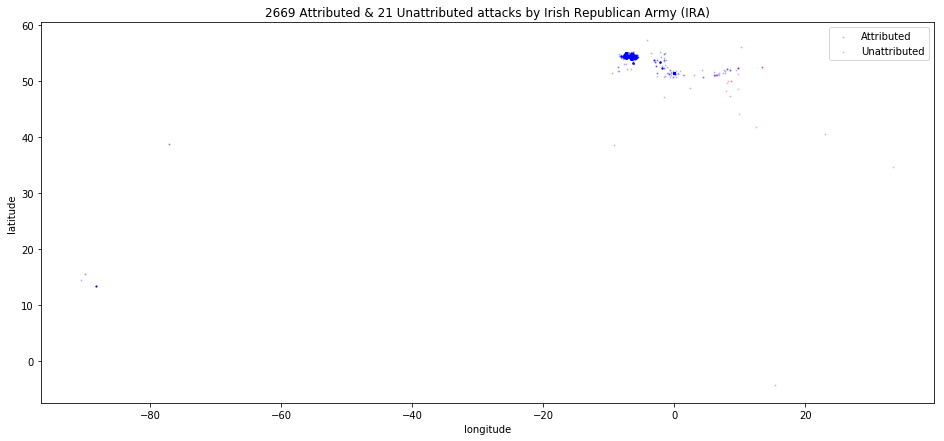

In [40]:
check_group = 1432 #IRA, one of the groups that wasn't classified with high accuracy above
plot_2map(df,df_unknown,check_group)
# This looks somewhat similar, but less dense. 

## Figure 15. Location of Attributed vs. Unattributed attacks by Irish Republican Army

### 4) Compare attack location for any random group:

No unattributed attacks were attributed to this group


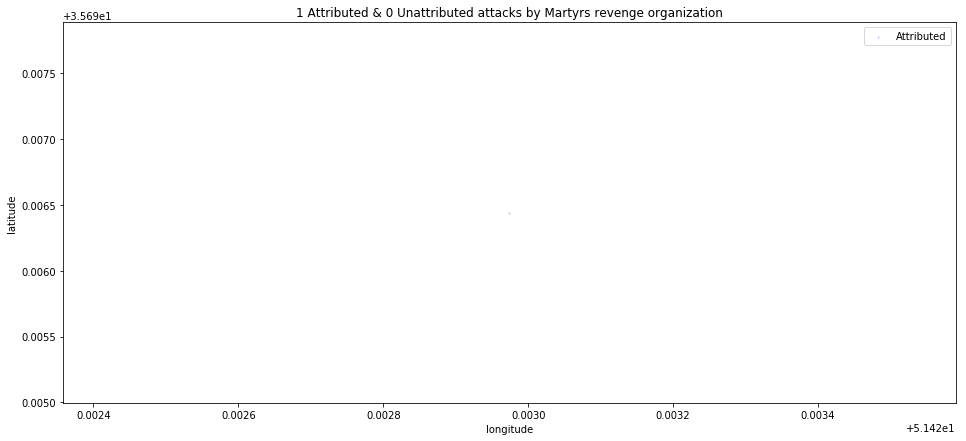

In [41]:
check_group = random.randint(0,ngroups)
plot_2map(df,df_unknown,check_group)

## Figure 16. Location of Attributed vs. Unattributed attacks by Randomly selected group